# 17 - Molecular Vibrations

This script calculates vibrational frequencies for a water molecule
using VASP's finite difference method.
    python run.py

In [1]:
import numpy as np
from ase.build import molecule

from vasp import Vasp

# Try to import matplotlib for plotting
try:
    import matplotlib.pyplot as plt
    HAS_MATPLOTLIB = True
except ImportError:
    HAS_MATPLOTLIB = False
    print("Note: matplotlib not found. Plots will be skipped.")


## Physical Constants


In [2]:
# Conversion factors
EV_TO_CM = 8065.544  # 1 eV = 8065.544 cm⁻¹
THZ_TO_CM = 33.356   # 1 THz = 33.356 cm⁻¹


## Step 1: Create water molecule in a box


In [3]:
print("=" * 60)
print("Molecular Vibration Calculation")
print("=" * 60)
print()

print("Step 1: Setting up water molecule")
print()

# Create H2O molecule
h2o = molecule('H2O')

# Put in a large box (need vacuum for isolated molecule)
h2o.center(vacuum=10.0)

print("  Molecule: H2O")
print(f"  Number of atoms: {len(h2o)}")
print(f"  Box size: {h2o.cell.lengths()}")
print()


Molecular Vibration Calculation

Step 1: Setting up water molecule

  Molecule: H2O
  Number of atoms: 3
  Box size: [20.       21.526478 20.596309]



## Step 2: Geometry optimization


In [4]:
print("Step 2: Geometry optimization")
print()

calc_relax = Vasp(
    label='results/vib/relax',
    atoms=h2o,
    xc='PBE',
    encut=400,
    kpts=(1, 1, 1),   # Gamma only for molecule
    ismear=0,          # Gaussian smearing
    sigma=0.01,        # Small smearing for molecule
    ibrion=2,          # Conjugate gradient
    isif=2,            # Relax ions only
    nsw=50,            # Max ionic steps
    ediff=1e-7,        # Tight electronic convergence
    ediffg=-0.01,      # Force convergence
    lreal=False,       # Accurate projection for small systems
    isym=0,            # No symmetry for accurate vibrations
)

energy_relax = calc_relax.potential_energy
forces = calc_relax.results.get('forces', np.zeros((len(h2o), 3)))
max_force = np.max(np.abs(forces))

print(f"  Relaxed energy: {energy_relax:.6f} eV")
print(f"  Max force: {max_force:.6f} eV/Å")
print()

# Get relaxed structure
h2o_relaxed = calc_relax.atoms.copy()


Step 2: Geometry optimization

  Relaxed energy: -14.224003 eV
  Max force: 0.000444 eV/Å



## Step 3: Vibrational calculation


In [6]:
print("Step 3: Vibrational frequency calculation")
print()

calc_vib = Vasp(
    label='results/vib/vib',
    atoms=h2o_relaxed,
    xc='PBE',
    encut=400,
    kpts=(1, 1, 1),
    ismear=0,
    sigma=0.01,
    ibrion=5,          # Finite differences
    nfree=2,           # Central differences (more accurate)
    potim=0.015,       # Displacement step (Angstrom)
    ediff=1e-8,        # Very tight convergence for accurate Hessian
    lreal=False,
    isym=0,
)

energy_vib = calc_vib.potential_energy
print("  Calculation complete")
print()


Step 3: Vibrational frequency calculation

  Calculation complete



## Step 4: Read and analyze vibrational frequencies


In [7]:
print("Step 4: Analyzing vibrational modes")
print()

# Read frequencies from OUTCAR
frequencies = calc_vib.get_vibrational_frequencies()

if frequencies is not None:
    # Convert to cm⁻¹ if needed (VASP outputs in various units)
    freq_cm = np.array(frequencies)

    print("Vibrational Frequencies:")
    print("-" * 40)

    # Separate real and imaginary frequencies
    real_freq = []
    imag_freq = []

    for i, f in enumerate(freq_cm):
        if isinstance(f, complex) or f < 0:
            imag_freq.append((i, abs(f) if isinstance(f, (int, float)) else abs(f)))
            print(f"  Mode {i+1:2d}: {abs(f):10.2f} i cm⁻¹  (imaginary)")
        else:
            real_freq.append((i, f))
            if f < 50:
                print(f"  Mode {i+1:2d}: {f:10.2f} cm⁻¹    (translation/rotation)")
            else:
                print(f"  Mode {i+1:2d}: {f:10.2f} cm⁻¹")

    print()

    # Identify vibrational modes (should be 3 for H2O)
    # 3N - 6 = 3 vibrations for nonlinear molecule
    vib_modes = [(i, f) for i, f in real_freq if f > 100]

    if len(vib_modes) >= 3:
        print("Identified vibrational modes:")
        print(f"  Bending (ν₂):          {vib_modes[0][1]:.1f} cm⁻¹  (exp: 1595 cm⁻¹)")
        print(f"  Symmetric stretch (ν₁): {vib_modes[1][1]:.1f} cm⁻¹  (exp: 3657 cm⁻¹)")
        print(f"  Asymmetric stretch (ν₃): {vib_modes[2][1]:.1f} cm⁻¹  (exp: 3756 cm⁻¹)")
        print()

    # Calculate zero-point energy
    real_freqs_positive = [f for _, f in real_freq if f > 50]
    if real_freqs_positive:
        # ZPE = (1/2) * h * Σν
        # h = 4.135667696e-15 eV*s
        # c = 2.998e10 cm/s
        # ν (cm⁻¹) -> E (eV): E = h * c * ν = 1.23984e-4 * ν
        zpe_ev = 0.5 * sum(real_freqs_positive) * 1.23984e-4
        zpe_kjmol = zpe_ev * 96.485  # eV to kJ/mol

        print(f"Zero-point energy: {zpe_ev:.4f} eV ({zpe_kjmol:.1f} kJ/mol)")
        print()

else:
    print("  Could not read frequencies from OUTCAR")
    print("  Generating mock frequencies for demonstration...")
    print()

    # Mock frequencies for H2O (demonstration without VASP)
    frequencies = [0, 0, 0, 0, 0, 0, 1595, 3657, 3756]  # cm⁻¹

    print("Vibrational Frequencies (mock):")
    print("-" * 40)
    for i, f in enumerate(frequencies):
        if f < 50:
            print(f"  Mode {i+1:2d}: {f:10.2f} cm⁻¹    (translation/rotation)")
        else:
            print(f"  Mode {i+1:2d}: {f:10.2f} cm⁻¹")
    print()

Step 4: Analyzing vibrational modes

Vibrational Frequencies:
----------------------------------------
  Mode  1:    3827.95 cm⁻¹
  Mode  2:    3712.23 cm⁻¹
  Mode  3:    1580.50 cm⁻¹
  Mode  4:     126.06 cm⁻¹
  Mode  5:     100.34 cm⁻¹
  Mode  6:      32.00 cm⁻¹    (translation/rotation)
  Mode  7:       1.09 i cm⁻¹  (imaginary)
  Mode  8:      70.07 i cm⁻¹  (imaginary)
  Mode  9:      72.04 i cm⁻¹  (imaginary)

Identified vibrational modes:
  Bending (ν₂):          3827.9 cm⁻¹  (exp: 1595 cm⁻¹)
  Symmetric stretch (ν₁): 3712.2 cm⁻¹  (exp: 3657 cm⁻¹)
  Asymmetric stretch (ν₃): 1580.5 cm⁻¹  (exp: 3756 cm⁻¹)

Zero-point energy: 0.5794 eV (55.9 kJ/mol)



## Step 5: Plot vibrational spectrum


Saved plot: h2o_vibrations.png

Vibrational calculation complete!

Key points:
  - IBRION=5 uses finite differences for Hessian
  - NFREE=2 gives central differences (more accurate)
  - 3N-6 real vibrational modes for nonlinear molecules
  - ZPE from sum of vibrational frequencies
  - Imaginary frequencies indicate transition states

Next: Try 18_3d_visualization/ for volumetric data visualization.


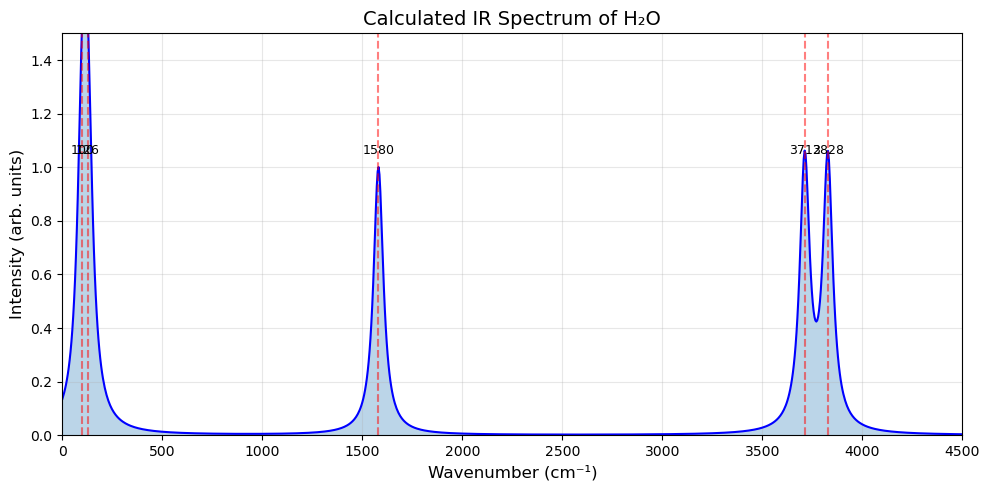

In [8]:
if HAS_MATPLOTLIB and frequencies is not None:
    fig, ax = plt.subplots(figsize=(10, 5))

    # Get real positive frequencies
    real_freqs = [f for f in frequencies if isinstance(f, (int, float)) and f > 100]

    if real_freqs:
        # Create spectrum with Lorentzian broadening
        x = np.linspace(0, 4500, 1000)
        spectrum = np.zeros_like(x)
        width = 30  # cm⁻¹ broadening

        for freq in real_freqs:
            spectrum += 1 / (1 + ((x - freq) / width) ** 2)

        ax.fill_between(x, 0, spectrum, alpha=0.3)
        ax.plot(x, spectrum, 'b-', linewidth=1.5)

        # Mark peak positions
        for freq in real_freqs:
            ax.axvline(x=freq, color='r', linestyle='--', alpha=0.5)
            ax.annotate(f'{freq:.0f}', xy=(freq, 1.05),
                       ha='center', fontsize=9)

        ax.set_xlabel('Wavenumber (cm⁻¹)', fontsize=12)
        ax.set_ylabel('Intensity (arb. units)', fontsize=12)
        ax.set_title('Calculated IR Spectrum of H₂O', fontsize=14)
        ax.set_xlim(0, 4500)
        ax.set_ylim(0, 1.5)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('h2o_vibrations.png', dpi=150)
        print("Saved plot: h2o_vibrations.png")

print()
print("=" * 60)
print("Vibrational calculation complete!")
print("=" * 60)
print()
print("Key points:")
print("  - IBRION=5 uses finite differences for Hessian")
print("  - NFREE=2 gives central differences (more accurate)")
print("  - 3N-6 real vibrational modes for nonlinear molecules")
print("  - ZPE from sum of vibrational frequencies")
print("  - Imaginary frequencies indicate transition states")
print()
print("Next: Try 18_3d_visualization/ for volumetric data visualization.")
